# Post-processing example
If you prefer to interact with a Python script instead, you can convert this notebook to *.py with `jupyter nbconvert --to script postprocessing_example.ipynb`.


In [1]:
# for more advanced hisfile operations: https://github.com/Deltares/dfm_tools/blob/main/tests/examples/postprocess_hisnc.py
# for more advanced mapfile operations: https://github.com/Deltares/dfm_tools/blob/main/tests/examples/postprocess_mapnc_ugrid.py
import xarray as xr
import matplotlib.pyplot as plt
import contextily as ctx
import numpy as np
import dfm_tools as dfmt


In [2]:
# set paths and parameters per model
# the necessary data is automatically downloaded from opendap if needed
model = 'grevelingen' # 'curvedbend' 'grevelingen' 'westernscheldt'

if model=='curvedbend': # sigma layers
    file_nc_his = dfmt.data.fm_curvedbend_his(return_filepath=True)
    file_nc_map = dfmt.data.fm_curvedbend_map(return_filepath=True)
    rename_mapvars = {}
    sel_slice_x, sel_slice_y = slice(1500,3500), slice(1000,3500)
    layer = 5
    crs = None
    raster_res = 100
    umag_clim = None
    scale = 1.5
    line_array = np.array([[ 104.15421399, 2042.7077107 ],
                           [2913.47878063, 2102.48057382]])
    remove_edges = False
elif model=='grevelingen': # z-layers
    file_nc_his = dfmt.data.fm_grevelingen_his(return_filepath=True)
    file_nc_map = dfmt.data.fm_grevelingen_map(return_filepath=True)
    rename_mapvars = {}
    sel_slice_x, sel_slice_y = slice(50000,55000), slice(None,424000)
    layer = 34
    crs = 'EPSG:28992'
    raster_res = 500
    umag_clim = None
    scale = 1.5
    line_array = np.array([[ 53181.96942503, 424270.83361629],
                           [ 55160.15232593, 416913.77136685]])
    remove_edges = False
elif model=='westernscheldt': # 2D
    file_nc_his = None
    file_nc_map = dfmt.data.fm_westernscheldt_map(return_filepath=True)
    rename_mapvars = {'mesh2d_FlowElem_bl':'mesh2d_flowelem_bl'}
    sel_slice_x, sel_slice_y = slice(None,3.8), slice(51.36,None)
    layer = None
    crs = 'EPSG:4326'
    raster_res = 0.01
    umag_clim = None
    scale = 50
    line_array = None #no mesh2d_sa1 available
    remove_edges = True
else:
    raise Exception(f'undefined model: {model}')


In [3]:
# open hisfile with xarray and print netcdf structure
if file_nc_his is not None:
    ds_his = xr.open_mfdataset(file_nc_his, preprocess=dfmt.preprocess_hisnc)
    vars_pd = dfmt.get_ncvarproperties(ds_his)
    vars_pd


Your model was run with a D-FlowFM version from before 28-10-2020 (D-Flow FM Version 1.2.41.63609 from Apr 08 2019), the layers in the hisfile are incorrect. Check UNST-2920 and UNST-3024 for more information, it was fixed from OSS 67858.


dropping 45 duplicate "source_sink_name" labels to avoid InvalidIndexError


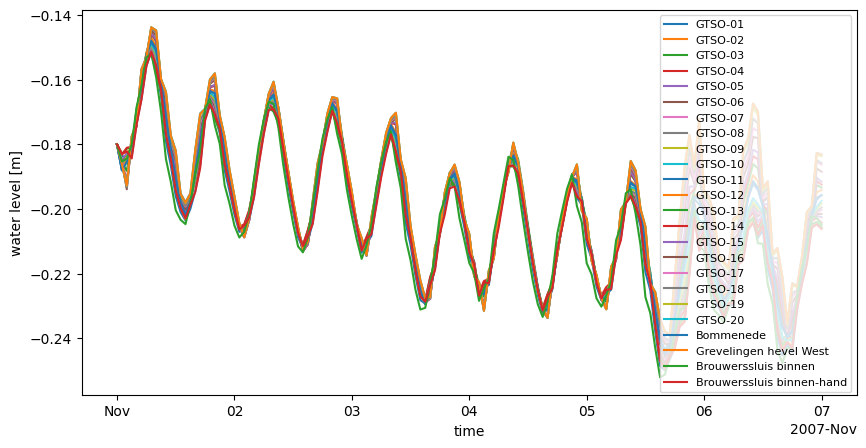

In [4]:
# plot his data: waterlevel at stations
if file_nc_his is not None:
    fig, ax = plt.subplots(1,1,figsize=(10,5))
    ds_his.waterlevel.plot.line(ax=ax, x='time')
    ax.legend(ds_his.stations.to_series(),loc=1,fontsize=8) #optional, to change legend location


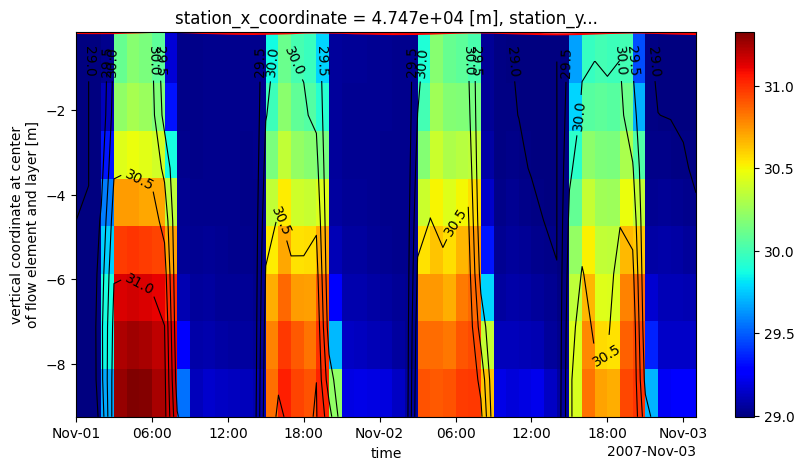

In [5]:
# plot his data: temperature zt at one station
if file_nc_his is not None:
    ds_his_sel = ds_his.isel(stations=0).isel(time=slice(0,50))
    fig, ax = plt.subplots(1,1,figsize=(10,5))
    ds_his_sel.waterlevel.plot.line(ax=ax,color='r') #waterlevel line
    pc = dfmt.plot_ztdata(ds_his_sel, varname='salinity', ax=ax, cmap='jet') #salinity pcolormesh
    fig.colorbar(pc,ax=ax)
    CS = dfmt.plot_ztdata(ds_his_sel, varname='salinity', ax=ax, only_contour=True, levels=6, colors='k', linewidths=0.8) #salinity contour
    ax.clabel(CS, fontsize=10)


In [6]:
# open+merge mapfile with xugrid(xarray) and print netcdf structure
uds_map = dfmt.open_partitioned_dataset(file_nc_map, remove_edges=remove_edges)
uds_map = uds_map.rename(rename_mapvars)
vars_pd = dfmt.get_ncvarproperties(uds_map)
vars_pd.head(10)


>> xu.open_dataset() with 8 partition(s): 1 2 3 4 5 6 7 8 : 2.29 sec
1.44 secrge_partitions() with 8 partition(s): 
>> some variables dropped with merging of partitions: ['mesh2d_face_x_bnd', 'mesh2d_face_y_bnd']
>> dfmt.open_partitioned_dataset() total: 3.73 sec


long_name  \
timestep                     Latest computational timestep size in each out...   
mesh2d_layer_z                            Vertical coordinate of layer centres   
projected_coordinate_system                                                      
mesh2d_interface_z                     Vertical coordinate of layer interfaces   
time                                                                             
mesh2d_node_z                                       z-coordinate of mesh nodes   
mesh2d_node_y                                       y-coordinate of mesh nodes   
mesh2d_node_x                                       x-coordinate of mesh nodes   
mesh2d_windx                 velocity of air on flow element center, x-comp...   
mesh2d_ucz                    Flow element center velocity vector, z-component   

                             units           shape  \
timestep                         s            (4,)   
mesh2d_layer_z                               (36,)   
projected_coordinate_system                     ()   
mesh2d_interface_z                           (37,)   
time                                          (4,)   
mesh2d_node_z                    m        (23108,)   
mesh2d_node_y                    m        (23108,)   
mesh2d_node_x                    m        (23108,)   
mesh2d_windx                 m s-1      (4, 44796)   
mesh2d_ucz                   m s-1  (4, 44796, 36)   

                                                      dimensions  \
timestep                                                 (time,)   
mesh2d_layer_z                                  (nmesh2d_layer,)   
projected_coordinate_system                                   ()   
mesh2d_interface_z                          (nmesh2d_interface,)   
time                                                     (time,)   
mesh2d_node_z                                    (nmesh2d_node,)   
mesh2d_node_y                                    (nmesh2d_node,)   
mesh2d_node_x                                    (nmesh2d_node,)   
mesh2d_windx                                (time, nmesh2d_face)   
mesh2d_ucz                   (time, nmesh2d_face, nmesh2d_layer)   

                                      dtype              standard_name unit  \
timestep                            float64                                   
mesh2d_layer_z                      float64                   altitude    m   
projected_coordinate_system           int32                                   
mesh2d_interface_z                  float64                   altitude    m   
time                         datetime64[ns]                       time        
mesh2d_node_z                       float64                   altitude        
mesh2d_node_y                       float64    projection_y_coordinate        
mesh2d_node_x                       float64    projection_x_coordinate        
mesh2d_windx                        float64                     x_wind        
mesh2d_ucz                          float64  upward_sea_water_velocity        

                                            name   epsg  grid_mapping_name  \
timestep                                                                     
mesh2d_layer_z                                                               
projected_coordinate_system  Amersfoort / RD New  28992  Unknown projected   
mesh2d_interface_z                                                           
time                                                                         
mesh2d_node_z                                                                
mesh2d_node_y                                                                
mesh2d_node_x                                                                
mesh2d_windx                                                                 
mesh2d_ucz                                                                   

                             ...    mesh location  \
timestep                     ...        

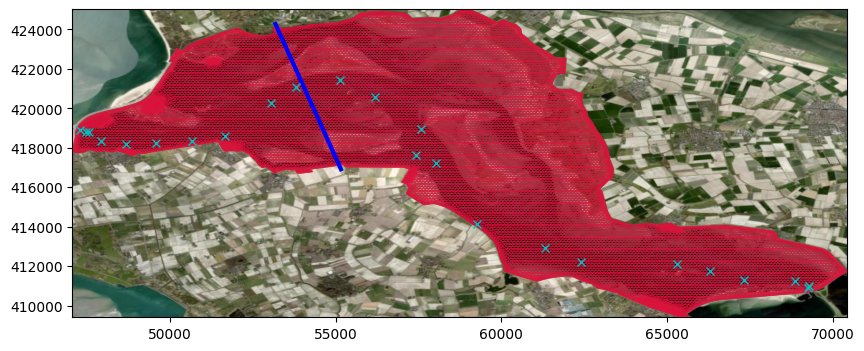

In [7]:
# plot net/grid. use random variable and plot line to get grid
fig, ax = plt.subplots(figsize=(10,4))
pc = uds_map.grid.plot(edgecolor='crimson', linewidth=0.5)
if crs is None:
    ax.set_aspect('equal')
else:
    ctx.add_basemap(ax=ax, source=ctx.providers.Esri.WorldImagery, crs=crs, attribution=False)
if line_array is not None:
    ax.plot(line_array[:,0],line_array[:,1],'b',linewidth=3)

# add stations locations
if file_nc_his is not None:
    ax.plot(ds_his['station_x_coordinate'], ds_his['station_y_coordinate'], 'xc')


>> rasterizing ugrid Dataset with 1 face variables to shape=(31,47): 0.53 sec


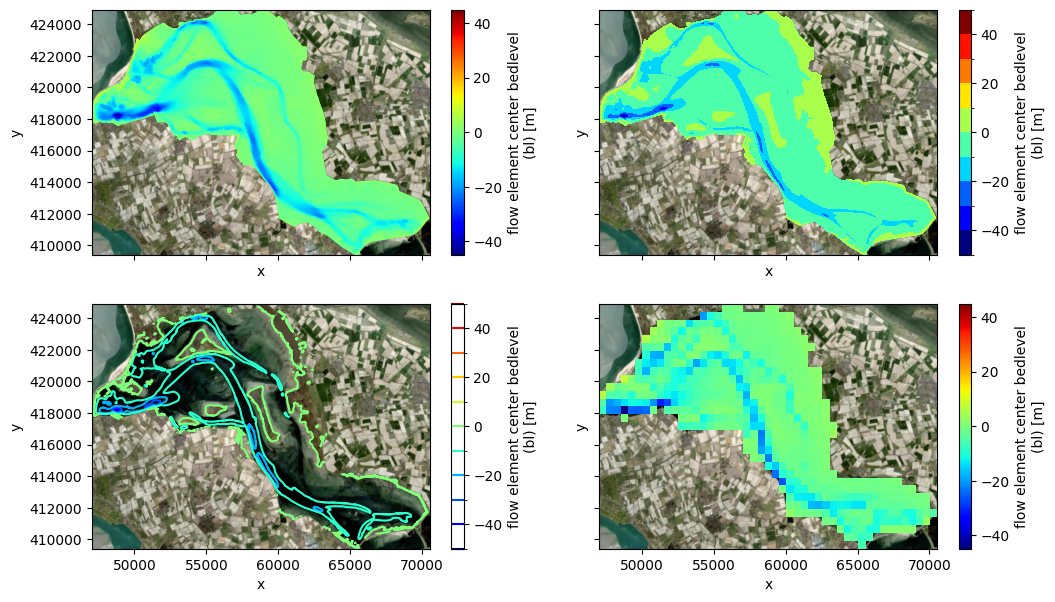

In [8]:
# plot bedlevel on map, including contour/contourf/rasterized
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(12,7),sharex=True,sharey=True)
pc = uds_map['mesh2d_flowelem_bl'].ugrid.plot(ax=ax1, cmap='jet')
pc = uds_map['mesh2d_flowelem_bl'].ugrid.plot.contourf(ax=ax2, levels=11, cmap='jet')
pc = uds_map['mesh2d_flowelem_bl'].ugrid.plot.contour(ax=ax3, levels=11, cmap='jet', add_colorbar=True)
bl_raster = dfmt.rasterize_ugrid(uds_map[['mesh2d_flowelem_bl']],resolution=raster_res) #rasterize ugrid
pc = bl_raster['mesh2d_flowelem_bl'].plot(ax=ax4, cmap='jet') #plot with non-ugrid method
for ax in (ax1,ax2,ax3,ax4):
    if crs is None:
        ax.set_aspect('equal')
    else:
        ctx.add_basemap(ax=ax, source=ctx.providers.Esri.WorldImagery, crs=crs, attribution=False)


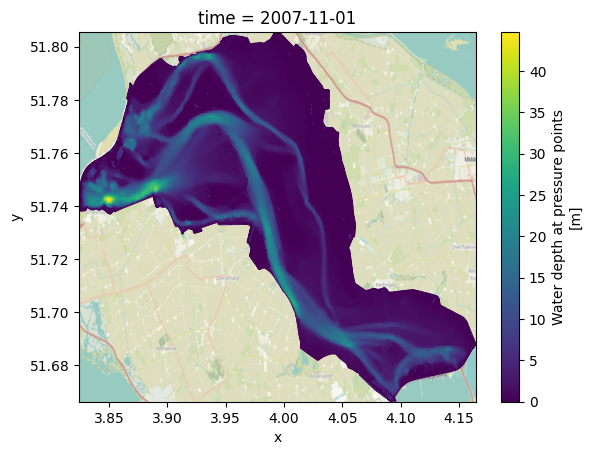

In [9]:
# convert coordinates
if crs == 'EPSG:28992':
    to_crs = 'EPSG:4326'
elif crs == 'EPSG:4326':
    to_crs = 'EPSG:28992'
if crs is not None:
    if model=='westernscheldt':
        uds_map.ugrid.set_crs(crs, allow_override=True) # westernscheldt file has incorrect crs information
    uds_map_conv = uds_map.ugrid.to_crs(to_crs)
    fig, ax = plt.subplots()
    uds_map_conv["mesh2d_waterdepth"].isel(time=0).ugrid.plot(ax=ax)
    ctx.add_basemap(ax=ax, source=None, crs=to_crs, attribution=False)


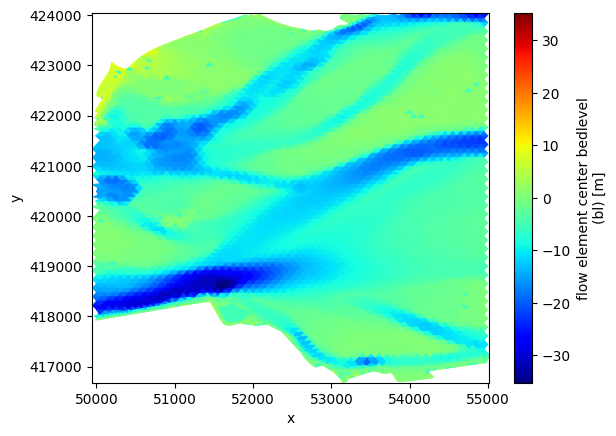

In [10]:
# ugrid sel via x/y
uds_map_sel = uds_map.ugrid.sel(x=sel_slice_x,y=sel_slice_y)
fig, ax = plt.subplots()
pc = uds_map_sel['mesh2d_flowelem_bl'].ugrid.plot(ax=ax, linewidth=0.5, cmap='jet')


edge-to-face interpolation: 0.08 sec
no interface dimension found, returning original array


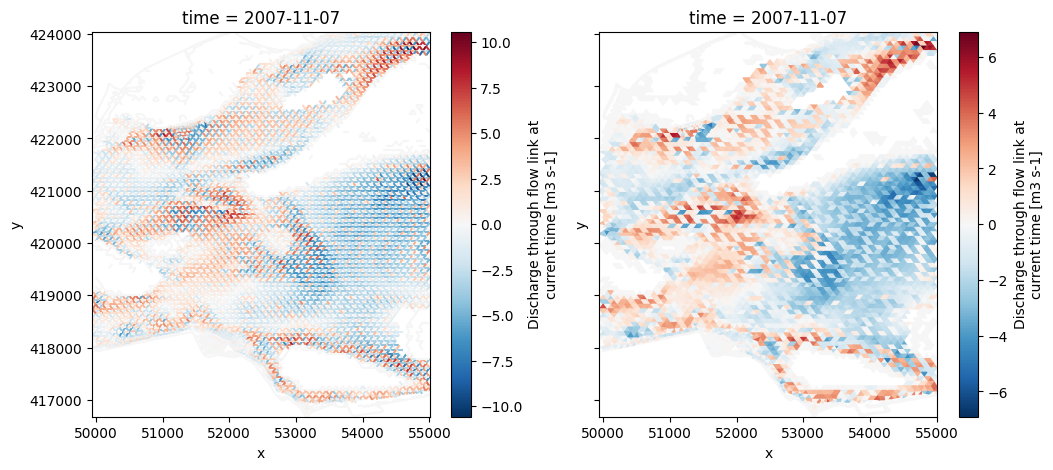

In [11]:
# interpolate edge variable to faces
uda_edge = uds_map_sel['mesh2d_q1']
uda_face_int = dfmt.uda_to_faces(uda_edge)
uda_face = dfmt.uda_interfaces_to_centers(uda_face_int)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5),sharex=True,sharey=True)
uda_edge.isel(time=-1, mesh2d_nLayers=layer, nmesh2d_layer=layer, missing_dims='ignore').ugrid.plot(ax=ax1)
uda_face.isel(time=-1, mesh2d_nLayers=layer, nmesh2d_layer=layer, missing_dims='ignore').ugrid.plot(ax=ax2)


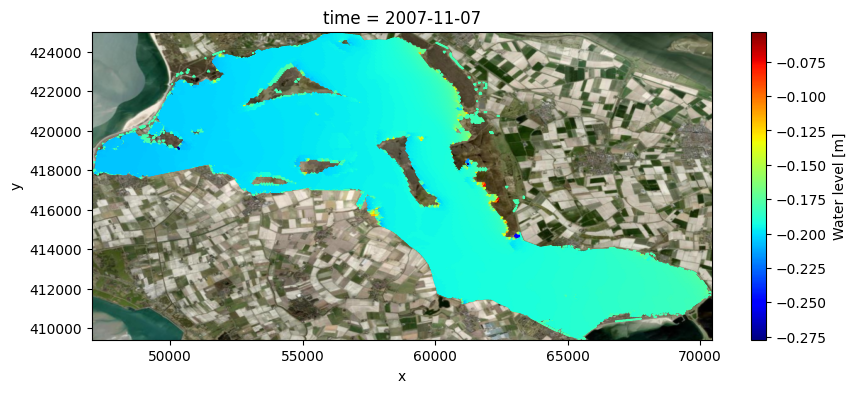

In [12]:
# filter dry cells
bool_drycells = uds_map['mesh2d_s1']==uds_map['mesh2d_flowelem_bl']
uds_map['mesh2d_s1_filt'] = uds_map['mesh2d_s1'].where(~bool_drycells)

# plot water level on map
fig, ax = plt.subplots(figsize=(10,4))
pc = uds_map['mesh2d_s1_filt'].isel(time=3).ugrid.plot(cmap='jet')
if crs is None:
    ax.set_aspect('equal')
else:
    ctx.add_basemap(ax=ax, source=ctx.providers.Esri.WorldImagery, crs=crs, attribution=False)


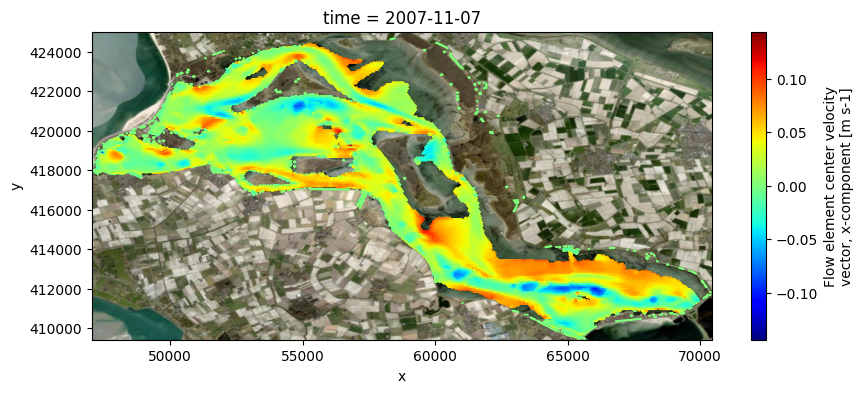

In [13]:
# plot eastward velocities on map, on layer
fig, ax = plt.subplots(figsize=(10,4))
pc = uds_map['mesh2d_ucx'].isel(time=3, mesh2d_nLayers=layer, nmesh2d_layer=layer, missing_dims='ignore').ugrid.plot(cmap='jet')
if crs is None:
    ax.set_aspect('equal')
else:
    ctx.add_basemap(ax=ax, source=ctx.providers.Esri.WorldImagery, crs=crs, attribution=False)


z-layer model, computing zw/zcc (fullgrid) values and treat as fullgrid model from here
0.45 sectting data on fixed depth in fullgrid z-data: 


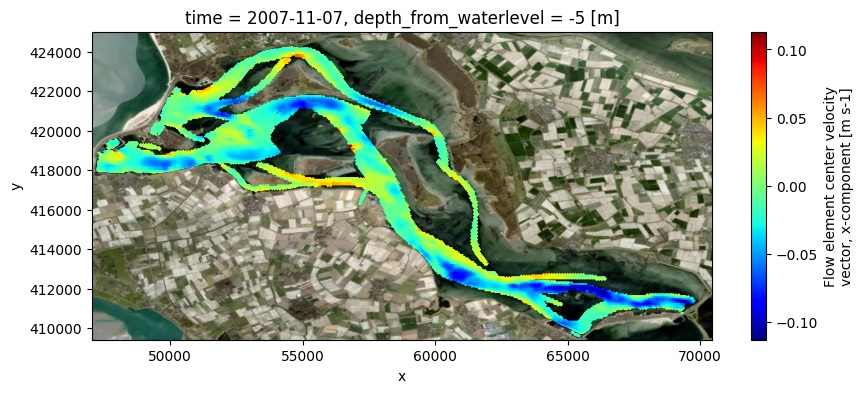

In [14]:
# plot eastward velocities on map, on depth from waterlevel/z0/bedlevel
uds_map_atdepths = dfmt.get_Dataset_atdepths(data_xr=uds_map.isel(time=3), depths=-5, reference='waterlevel')
fig, ax = plt.subplots(figsize=(10,4))
pc = uds_map_atdepths['mesh2d_ucx'].ugrid.plot(cmap='jet')
if crs is None:
    ax.set_aspect('equal')
else:
    ctx.add_basemap(ax=ax, source=ctx.providers.Esri.WorldImagery, crs=crs, attribution=False)


>> rasterizing ugrid Dataset with 2 face variables to shape=(31,47): 0.01 sec


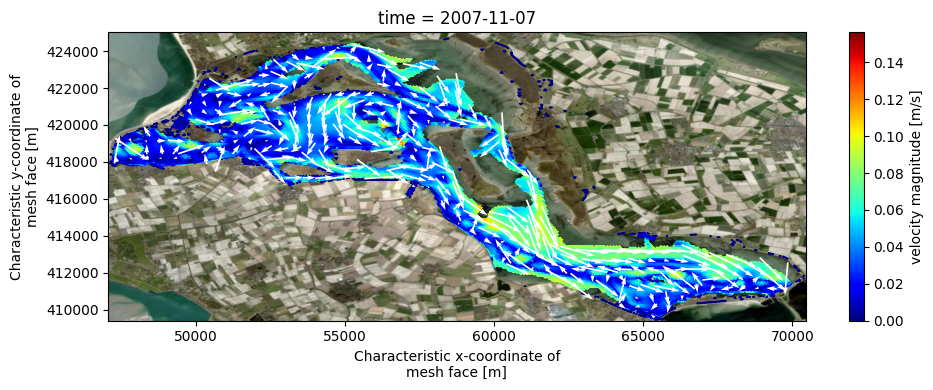

In [15]:
# velocity magnitude and quiver
uds_quiv = uds_map.isel(time=-1, mesh2d_nLayers=-2, nmesh2d_layer=-2, missing_dims='ignore')
varn_ucx, varn_ucy = 'mesh2d_ucx', 'mesh2d_ucy'
magn_attrs = {'long_name':'velocity magnitude', 'units':'m/s'}
uds_quiv['magn'] = np.sqrt(uds_quiv[varn_ucx]**2 + uds_quiv[varn_ucy]**2).assign_attrs(magn_attrs)
raster_quiv = dfmt.rasterize_ugrid(uds_quiv[[varn_ucx,varn_ucy]], resolution=raster_res)

# plot
fig,ax = plt.subplots(figsize=(10,4))
pc = uds_quiv['magn'].ugrid.plot(cmap='jet')
raster_quiv.plot.quiver(x='mesh2d_face_x', y='mesh2d_face_y', u=varn_ucx, v=varn_ucy, color='w', scale=scale, add_guide=False)
pc.set_clim(umag_clim)
fig.tight_layout()
if crs is None:
    ax.set_aspect('equal')
else:
    ctx.add_basemap(ax=ax, source=ctx.providers.Esri.WorldImagery, crs=crs, attribution=False)


z-layer model, computing zw/zcc (fullgrid) values and treat as fullgrid model from here


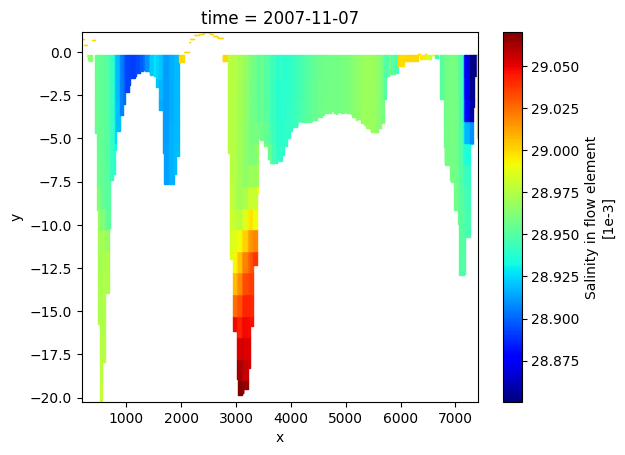

In [16]:
# plot slice/sideview trough 3D salinity mapdata
if line_array is not None:
    uds_crs = dfmt.polyline_mapslice(uds_map.isel(time=3), line_array)
    fig, ax = plt.subplots()
    uds_crs['mesh2d_sa1'].ugrid.plot(cmap='jet')
